In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
from typing import List, Tuple

from cartpole_dynamics import CartpoleDynamics
from dynamics import *
from quadratic_program import QuadraticProgram
from solvers import InfeasibleStartNewton, FeasibleStartNewton

In [2]:
np.set_printoptions(threshold=np.inf)

## References

https://cse.lab.imtlucca.it/~bemporad/publications/papers/ijc_rtiltv.pdf

https://web.stanford.edu/~boyd/papers/pdf/fast_mpc.pdf

https://www.imtek.de/professuren/systemtheorie/events/dateien/directshootingmethods

https://www.matthewpeterkelly.com/tutorials/trajectoryOptimization/cartPoleCollocation.svg#frame1114

In [3]:
def pendulum_position(z: np.ndarray, l_pend: float):
    '''
    Returns the position of the mass at the end of a pendulum attached to a cart given some current system state.
    - z = Cartpole system state: [cart position, pendulum angle, cart speed, pendulum angular speed]
    - l_pend = Length of a pendulum
    '''
    return np.array([z[0] + l_pend * np.sin(z[1]), -l_pend * np.cos(z[1])])

In [4]:
def plot_pendulum_time_sequence(states: List, l_pend: float, keyframe_stride: int=4, filename: str=None):
    '''
    Plots the cart position, pendulum arm, and pendulum mass position for a sequence of 4d
    states indicating the system's [cart_pos, pendulum_angle, cart_speed, pendulum_angular_speed].

    Add shapes to matplotlib plot:
    https://www.scaler.com/topics/matplotlib/plot-shape-matplotlib/

    - states = List of cartpole states
    - l_pend = Length of the pendulum
    - keyframe_stride = Number of frames to skip plotting the whole cartpole system
    - filename = Name of the file to save the plot to
    '''

    positions = [pendulum_position(z, l_pend) for z in states]

    keyframe_states = [s for i, s in enumerate(states) if (i % keyframe_stride) == 0]
    keyframe_colors = cm.rainbow(np.linspace(0, 1, int(len(states) / keyframe_stride) + 1))
    colors = cm.rainbow(np.linspace(0, 1, len(states)))
    fig = plt.figure()
    ax = fig.add_subplot()
    # ax.set_ylim([-1.25 * l_pend, 1.25 * l_pend])
    for i, ks in enumerate(keyframe_states):
        cart = plt.Rectangle((ks[0] - 0.125/2, 0.0), 0.125, 0.125/2, fc=keyframe_colors[i])
        plt.plot([ks[0], ks[0] + l_pend * np.sin(ks[1])], [0.0, -l_pend * np.cos(ks[1])], color=keyframe_colors[i])
        plt.gca().add_patch(cart)
    plt.scatter([p[0] for p in positions], [p[1] for p in positions], color=colors, s=0.25)
    
    # plt.axis('equal')
    plt.ylim(-1.25 * l_pend, 1.25 * l_pend)
    plt.gca().set_aspect('equal')
    if filename is not None:
        plt.savefig(filename, dpi=8000.0, bbox_inches='tight')

    fig = plt.figure()
    plt.title("pendulum angle")
    plt.plot([z[1] for z in states])
    fig = plt.figure()
    plt.title("position")
    plt.plot([z[0] for z in states])

    plt.show()

In [5]:
def cartpole_demo(z_init: np.ndarray, u_init: float, t_max: float, u_max: float=1.0):
    zs = []
    zs.append(copy.copy(z_init))
    dt = 0.01

    cp_dynamics = CartpoleDynamics(1.0, 1.0, 1.0, -u_max, u_max)

    for i in range(int(t_max / dt)):
        zs.append(cp_dynamics.step(zs[-1], u_init, dt, dt * i))

    plot_pendulum_time_sequence(zs, 1.0)

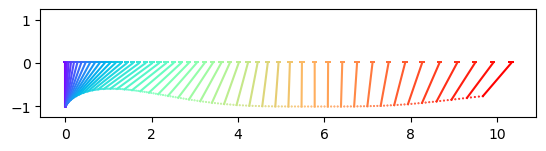

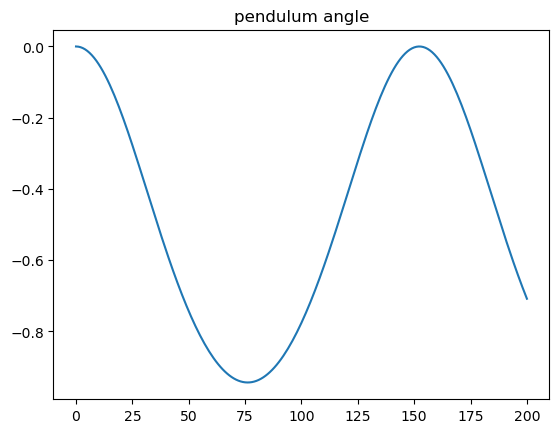

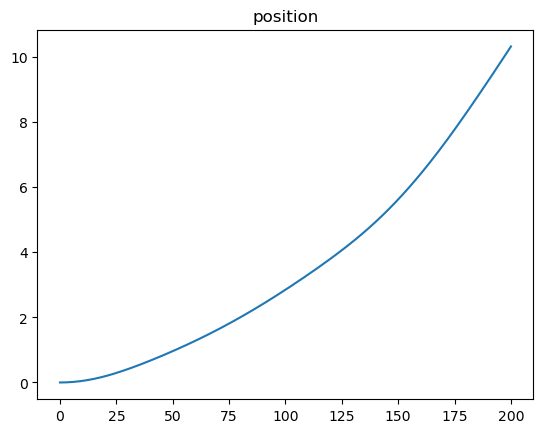

In [6]:
cartpole_demo(np.array([0.0, 0.0, 0.0, 0.0]), 10.0, 2, u_max=10.0)

The dynamics of a system are governed by

$\dot{\mathbf{z}} = f(t, \mathbf{z}, u)$

where $t$ is time, $\mathbf{z}$ is the system's state, and $u$ is a control input applied to the system. Then the system's linearized dynamics are given by

$\dot{\mathbf{z}} = f(t, \mathbf{z}, u) \approx f(t_0, \mathbf{z}_0, u_0) + \nabla_{\mathbf{z}}f(t_0, \mathbf{z}_0, u_0)^T (\mathbf{z} - \mathbf{z}_0) + \nabla_uf(t_0, \mathbf{z}_0, u_0)^T(u - u_0)$

or, using the terms from the following function,

$\dot{\mathbf{z}} = \mathbf{r}(t_0, \mathbf{z}_0, u_0) + A \mathbf{z} + \mathbf{b}u$

for some initial time, state, and control input.

\begin{equation}
x(t) = e^{A(t - t_0)}x(t_0) + e^{At}\int_{t_0}^{t}e^{A\tau} \left( b u(\tau) + f \right) d\tau
\end{equation}

When $u(\tau) = u_0$ for $t_0 \leq t \leq t$ the convolution integral becomes

\begin{equation}
x(t) = e^{A(t - t_0)}x(t_0) + \left( e^{A(t - t_0)} - \mathbb{I} \right)A^{-1}(b u_0 + f)
\end{equation}

$A \in \mathbb{R}^{n \times n}$ is the Jacobian of the nonlinear system dynamics with respect to $x \in \mathbb{R}^n$

$b \in \mathbb{R}^n$ is the Jacobian of the nonlinear system dynamics with respect to $u \in \mathbb{R}$

$f \in \mathbb{R}^n$ is the constant term that comes from linearizing the system dynamics about a non-fixed point

The state transition matrix is defined as

\begin{equation}
\Phi(t) = e^{At}
\end{equation}

and transitioning from one state to the next state is done via

\begin{equation}
\mathbf{x}_{t+\delta t} = \Phi(t + \delta t, t) \mathbf{x}_{t}
\end{equation}

In [8]:
def plot_time_sequence(positions: List[np.ndarray]):
    '''
    Plots a sequence of 2d positions in the xy plane, where x and y indicate the position of
    *something* that has evolved over time.

    - positions = List of 2d positions
    '''
    colors = cm.rainbow(np.linspace(0, 1, len(positions)))
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.scatter([p[0] for p in positions], [p[1] for p in positions], color=colors)
    ax.axis('equal')
    plt.show()

In [9]:
def plot_control_input(us: List[np.ndarray], dt, filename: str = None):
    '''
    Plots a sequence of control inputs

    - us = A sequence of control inputs
    - dt = Time duration over which the LTI system is simulated
    - filename = Name of the file the plot should be saved to
    '''

    t_vals = [dt * n for n in range(len(us))]
    plt.plot(t_vals, [u for u in us])
    # plt.plot([u for u in us])
    plt.xlabel("Time (s)")
    plt.ylabel("Control effort")
    plt.show()
    if filename is not None:
        plt.savefig(filename, dpi=800.0, bbox_inches='tight')


In [10]:
def build_A_and_c_mat_exp(
    F: np.ndarray,
    b: np.ndarray,
    f_0: np.ndarray,
    z_init: np.ndarray,
    z_final: np.ndarray,
    N: int,
    dt: float
):
    '''
    Builds the parameters of the linear equation Ax = c from the
    parameters of an LTI dynamical system using a Taylor series
    expansion of the matrix exponential solution to the dynamic equation
    z_dot = F * z + b * u + f_0. `A` and `c` are collocation constraints
    on the dynamics of a system.

    - F - F matrix of z_dot = Fz + bu + f_0
    - b - b vector of z_dot = Fz + bu + f_0
    - f_0 - f vector of z_dot = Fz + bu + f_0
    - N - the number of time points
    - dt - delta time between time points
    '''

    phi, phi_integ = phi_and_phi_integ(F, dt)
    
    state_vec_size = np.shape(z_init)[0]
    # `state_vec_size * 2` extra rows are tacked on to `A` and `c`
    # to handle the boundary constraints on `z_0` and `z_N`
    A = np.zeros((state_vec_size * (N + 2), (state_vec_size + 1) * (N + 1)))
    c = np.zeros(state_vec_size * (N + 2))

    # The index in the vector of decision variables where the first element of the
    # state vector from the dynamical system at the first time step appears
    control_input_offset = N + 1
    for i in range(N):
        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            i
        ] = -np.dot(phi_integ, b)

        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            control_input_offset + i * state_vec_size : control_input_offset + i * state_vec_size + state_vec_size
        ] = -phi

        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            control_input_offset + (i + 1) * state_vec_size : control_input_offset + (i + 1) * state_vec_size + state_vec_size
        ] = np.eye(state_vec_size)

        c[i * state_vec_size : i * state_vec_size + state_vec_size] = np.dot(phi_integ, f_0)

    A[
        N * state_vec_size: N * state_vec_size + state_vec_size,
        control_input_offset + 0: control_input_offset + 0 + state_vec_size
    ] = np.eye(state_vec_size)

    c[N * state_vec_size: N * state_vec_size + state_vec_size] = z_init

    A[
        (N + 1) * state_vec_size: (N + 1) * state_vec_size + state_vec_size,
        control_input_offset + N * state_vec_size: control_input_offset + N * state_vec_size + state_vec_size
    ] = np.eye(state_vec_size)

    c[(N + 1) * state_vec_size: (N + 1) * state_vec_size + state_vec_size] = z_final

    return A, c

In [11]:
def build_A_and_c_multi_mat_exps(
    Fs: List[np.ndarray],
    bs: List[np.ndarray],
    f_0s: List[np.ndarray],
    z_init: np.ndarray,
    z_final: np.ndarray,
    N: int,
    dt: float
):
    '''
    Builds the parameters of the linear equation Ax = c from the
    parameters of an LTI dynamical system using a Taylor series
    expansion of the matrix exponential solution to the dynamic equation
    z_dot = F * z + b * u + f_0 about all collocation points in the trajectory.
    `A` and `c` are collocation constraints on the dynamics of a system.

    - Fs - List of F matrices, where Fs[k] is the F matrix of of z_dot = Fz + bu + f_0
      for some state z_k and control u_k
    - bs - List of b vectors, where bs[k] is the b vector of z_dot = Fz + bu + f_0 for
      some state z_k and control u_k
    - f_0s - List of f_0 vectors, where f_0s[k] is the f_0 vector of z_dot = Fz + bu + f_0
      for some state z_k and control u_k
    - N - the number of time points, also the number of elements in `Fs`, `bs`, and `f_0s`
    - dt - delta time between time points
    '''

    print(len(Fs))
    print(len(bs))
    print(len(f_0s))
    print(N)
    assert(len(Fs) == N)
    assert(len(bs) == N)
    assert(len(f_0s) == N)

    state_vec_size = np.shape(z_init)[0]
    # `state_vec_size * 2` extra rows are tacked on to `A` and `c`
    # to handle the boundary constraints on `z_0` and `z_N`
    A = np.zeros((state_vec_size * (N + 2), (state_vec_size + 1) * (N + 1)))
    c = np.zeros(state_vec_size * (N + 2))

    # The index in the vector of decision variables where the first element of the
    # state vector from the dynamical system at the first time step appears
    control_input_offset = N + 1
    for i in range(N):

        phi, phi_integ = phi_and_phi_integ(Fs[i], dt)

        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            i
        ] = -np.dot(phi_integ, bs[i])

        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            control_input_offset + i * state_vec_size : control_input_offset + i * state_vec_size + state_vec_size
        ] = -phi

        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            control_input_offset + (i + 1) * state_vec_size : control_input_offset + (i + 1) * state_vec_size + state_vec_size
        ] = np.eye(state_vec_size)

        c[i * state_vec_size : i * state_vec_size + state_vec_size] = np.dot(phi_integ, f_0s[i])

    A[
        N * state_vec_size: N * state_vec_size + state_vec_size,
        control_input_offset + 0: control_input_offset + 0 + state_vec_size
    ] = np.eye(state_vec_size)

    c[N * state_vec_size: N * state_vec_size + state_vec_size] = z_init

    A[
        (N + 1) * state_vec_size: (N + 1) * state_vec_size + state_vec_size,
        control_input_offset + N * state_vec_size: control_input_offset + N * state_vec_size + state_vec_size
    ] = np.eye(state_vec_size)

    c[(N + 1) * state_vec_size: (N + 1) * state_vec_size + state_vec_size] = z_final

    return A, c

In [ ]:
def linearize_about_trajectory(xs: np.ndarray, us:np.ndarray, dynamics: CartpoleDynamics) -> Tuple[List, List, List]:
   '''
   Calculates the linearized dynamics of a cartpole system about multiple states. Returns a tuple with lists of F matrices, b vectors, and
   f_0 vectors. Returns a tuple of `(Fs, bs, f_0s)`
   - xs = Numpy array with shape [N, 4] where the index of the first dimension is the index of a collocation point and the index of
   the second dimension is one of the elements of a system's state.
   - us = Numpy array with shape [N] whose elements are forces applied to the cart at different collocation points
   '''
   assert(len(xs) == len(us))

   Fs = []
   bs = []
   f_0s = []
   for i in range(len(xs)):
      (F, b, f_0) = dynamics.x_dot_linear(xs[i], us[i], 0.0)
      Fs.append(F)
      bs.append(b)
      f_0s.append(f_0)

   return (Fs, bs, f_0s)

## Trajectory Optimization

In [ ]:
def cartpole_trajectory_optimizer(
   N,
   T,
   effort_weights,
   z_0,
   z_final,
   dynamics: CartpoleDynamics,
   plot_stuff=True,
   filename=None
):
   assert(np.size(effort_weights) == N + 1)
   state_vec_size = 4
   # Initialize the quadratic weighting for control effort (only upper (N+1) x (N+1) corner is used)
   Q = np.zeros(((N + 1) * (state_vec_size + 1), (N + 1) * (state_vec_size + 1)))
   Q[0:(N + 1), 0:(N + 1)] = np.diag(effort_weights)

   assert(T > 0)
   assert(N > 0)

   # Delta time between steps
   dt = T / N

   assert(dt > 0)
   assert(dt < 1)

   # Initial state, used for linearizing dynamics
   u_0 = (dynamics._u_max + dynamics._u_min) / 2.0
   t_0 = 0.0

   F, b, f = dynamics.x_dot_linear(z_0, u_0, t_0)

   A, c = build_A_and_c_mat_exp(F, b, f, z_0, z_final, N, dt)

   # zs for warm-starting infeasible newton
   delta_tau = (1.0 / N)
   warm_zs = [(1 - i * delta_tau) * z_0 + i * delta_tau * z_final for i in range(N + 1)]
   warm_us = [0.000,] * (N + 1)

   print("z_0: ", warm_zs[0])
   print("z_f: ", warm_zs[-1])

   x_init = np.hstack(warm_us + warm_zs)
   v_init = np.ones(state_vec_size * (N + 2)) * 0.01

   barrier_t = 20.0

   C = np.zeros((2 * (N + 1), (N + 1) * (state_vec_size + 1)))
   C[0:(N + 1), 0: (N + 1)] = np.eye(N + 1)
   C[(N + 1):2*(N + 1), 0: (N + 1)] = -np.eye(N + 1)

   d = np.zeros((2 * (N + 1),))
   d[0: (N + 1)] = dynamics._u_max
   d[(N + 1):] = -dynamics._u_min

   qp = QuadraticProgram(Q, np.zeros(((N + 1) * (state_vec_size + 1))), A, c, C, d)
   isnm = InfeasibleStartNewton(qp)

   x_out, v_out, residual = isnm.solve(x_init, v_init, barrier_t, 0.5, 0.9, 100)

   if residual > 1e-5:
      print("infeasible with residual", residual)
      return False
   else:
      print("feasible with residual", residual)

   fsnm = FeasibleStartNewton(qp)

   barrier_lambda = 10.0
   for i in range(10):
      print("feasible newton iter", i)
      barrier_t *= barrier_lambda
      x_out, v_out, keep_going = fsnm.solve(x_out, v_out, barrier_t, 0.5, 0.9, 100)
      if not keep_going:
         break

   states = np.reshape(x_out[N + 1:], ((N + 1), state_vec_size))
   dense_zs = [z for z in states]

   if plot_stuff:
      z_0_str = "_".join([str(v) for v in z_0.tolist()])
      z_f_str = "_".join([str(v) for v in z_final.tolist()])
      config_str = f'_T={T}_N={N}_z0={z_0_str}_zf={z_f_str}_'

      control_input_filename = None
      trajectory_filename = None
      if filename is not None:
         control_input_filename = filename + config_str + "_control_inputty.png"
         trajectory_filename = filename + config_str + "_cartpole_swingy.png"
      
      plot_pendulum_time_sequence(dense_zs, dynamics._l_pend, 8, trajectory_filename)
      plot_control_input(x_out[:N + 1], dt, control_input_filename)

In [ ]:
def better_cartpole_trajectory_optimizer(
   N,
   T,
   effort_weights,
   z_0,
   z_final,
   dynamics: CartpoleDynamics,
   plot_stuff=True, filename=None
):
   '''
   Relinearizes cartpole dynamics about its collocation points in between alternating calls to `infeasible_newton` and `feasible_newton`.

   - N = Number of points in the trajectory
   - T = Final time
   - effort_weights = A vector of size N + 1 where each term is a penalty for applying control input at time index `i`
   - u_min = Minimum possible force exerted on the cart
   - u_max = Maximum possible force exerted on the cart
   - z_0 = Initial cartpole state
   - z_final = Desired final cartpole state
   - m_pend = Pendulum mass
   - l_pend = Pendulum length
   '''
   assert(np.size(effort_weights) == N + 1)
   state_vec_size = 4
   # Initialize the quadratic weighting for control effort (only upper (N+1) x (N+1) corner is used)
   Q = np.zeros(((N + 1) * (state_vec_size + 1), (N + 1) * (state_vec_size + 1)))
   Q[0:(N + 1), 0:(N + 1)] = np.diag(effort_weights)
   
   assert(T > 0)
   assert(N > 0)
   
   # Delta time between steps
   dt = T / N
   
   assert(dt > 0)
   assert(dt < 1)
   
   # Initial state, used for linearizing dynamics
   u_0 = (dynamics._u_max + dynamics._u_min) / 2.0
   t_0 = 0.0
   
   F, b, f = dynamics.x_dot_linear(z_0, u_0, t_0)

   print("F:", F)
   print("b:", b)
   print("f:", f)
   
   A, c = build_A_and_c_mat_exp(F, b, f, z_0, z_final, N, dt)
   
   # zs for warm-starting infeasible newton
   delta_tau = (1.0 / N)
   warm_zs = [(1 - i * delta_tau) * z_0 + i * delta_tau * z_final for i in range(N + 1)]
   warm_us = [0.000,] * (N + 1)
   
   print("z_0: ", warm_zs[0])
   print("z_f: ", warm_zs[-1])
   
   x_init = np.hstack(warm_us + warm_zs)
   v_init = np.ones(state_vec_size * (N + 2)) * 0.01
   
   print("x init shape:", np.shape(x_init))
   print("Q shape: ", np.shape(Q))

   C = np.zeros((2 * (N + 1), (N + 1) * (state_vec_size + 1)))
   C[0:(N + 1), 0: (N + 1)] = np.eye(N + 1)
   C[(N + 1):2*(N + 1), 0: (N + 1)] = -np.eye(N + 1)

   d = np.zeros((2 * (N + 1),))
   d[0: (N + 1)] = dynamics._u_max
   d[(N + 1):] = -dynamics._u_min

   qp = QuadraticProgram(Q, np.zeros(((N + 1) * (state_vec_size + 1))), A, c, C, d)
   isnm = InfeasibleStartNewton(qp)
   fsnm = FeasibleStartNewton(qp)

   # Outer loop over the number of relinearization iterations? Should go like:
   #  1. Run infeasible Newton
   #  2. Run feasible Newton for the fixed number of steps
   #  3. Relinearize system dynamics from collocation points from output of #2

   trajectories = []
   x_out = None
   v_out = None
   x_out2 = None
   for relin_step in range(10):
      barrier_t = 20.0

      # # experiment to try and get a minimum norm solution to the dynamics and initial/final state constraints
      # x_temp = np.dot(np.transpose(A), np.linalg.solve(np.dot(A, np.transpose(A)), c))

      # if plot_stuff:
      #     print("janky minimum norm solution to relinearized problem")
      #     dt = T / (N * 32)
      #     dense_zs = [z for z in np.reshape(x_temp[N + 1:], ((N + 1), state_vec_size))]
      #     print("equality constraints norm", np.linalg.norm(np.dot(A, x_temp) - c))
      #     plot_pendulum_time_sequence(dense_zs, l_pend, 8)
      #     plot_control_input(x_temp[:N + 1], dt)

      # x_init = x_temp

      max_infeasible_newton_iters = 100
      print("relin step:", relin_step)
      if (relin_step > 0):
         max_infeasible_newton_iters = 100
         x_init = x_out
         v_init = v_out

      x_out, v_out, residual = isnm.solve(x_init, v_init, barrier_t, max_num_iters=max_infeasible_newton_iters)

      if (residual > 1e-5):
         print("Problem is infeasible")
         return False

      barrier_lambda = 10.0
      for _ in range(10):
         print("feasible newton")
         barrier_t *= barrier_lambda
         x_out, v_out, keep_going = fsnm.solve(x_out, v_out, barrier_t, max_num_iters=100)
         if not keep_going:
               break
      x_out2 = copy.deepcopy(x_out)
      trajectories.append(x_out)

      if plot_stuff:
         dt = T / (N * 32)
         dense_zs = [z for z in np.reshape(x_out2[N + 1:], ((N + 1), state_vec_size))]
         print("equality constraints norm", np.linalg.norm(np.dot(A, x_out) - c))
         plot_pendulum_time_sequence(dense_zs, dynamics._l_pend, 8)
         plot_control_input(x_out2[:N + 1], dt)

      # Keep all but the last control input and system state
      us = x_out2[:(N + 1)]
      us = us[:-1]
      zs = x_out2[(N + 1):]
      # '-4' because there are four variables in each system state and the system states are flat when extracted
      # from the decision variable
      zs = zs[:-4]
      zs = np.reshape(zs, (N, 4))
      # Fs, bs, f_0s = linearize_about_trajectory(zs, us, u_max, m_cart, m_pend, l_pend)
      Fs, bs, f_0s = linearize_about_trajectory(zs, us, dynamics)

      # insert linearization from initial state into system constants
      Fs = Fs[1:]
      Fs.insert(0, F)
      bs = bs[1:]
      bs.insert(0, b)
      f_0s = f_0s[1:]
      f_0s.insert(0, f)

      A, c = build_A_and_c_multi_mat_exps(Fs, bs, f_0s, z_0, z_final, N, dt)
      isnm.qp.initialize(isnm.qp.Q, isnm.qp.p, A, c, isnm.qp.C, isnm.qp.d)
      fsnm.qp.initialize(fsnm.qp.Q, fsnm.qp.p, A, c, fsnm.qp.C, fsnm.qp.d)
      print("Fs[0]:", Fs[0])
      print("bs[0]:", bs[0])
      print("f_0s[0]:", f_0s[0])

   z_0_str = "_".join([str(v) for v in z_0.tolist()])
   z_f_str = "_".join([str(v) for v in z_final.tolist()])
   
   config_str = f'_T={T}_N={N}_z0={z_0_str}_zf={z_f_str}_'

   return True

## Modifiable parameters

Some configurations might make the problem infeasible.

In [45]:
# Number of timesteps
N = 128
# Total amount of time
T = 32

control_weighting = np.ones(N + 1)

u_min = -300
u_max = 300

z_0 = np.array([0.0, 0.0, 0.0, 0.0])
z_final = np.array([1.0, np.pi, 0.0, 0.0])

m_pend = 0.3
m_cart = 0.3
l_pend = 0.5

dynamics = CartpoleDynamics(l_pend, m_pend, m_cart, u_min, u_max)

In [46]:
# cartpole_trajectory_optimizer(N, T, control_weighting, z_0, z_final, dynamics)

F: [[  0.    0.    1.    0. ]
 [  0.    0.    0.    1. ]
 [  0.    9.8   0.    0. ]
 [  0.  -39.2   0.   -0. ]]
b: [ 0.  0.  1. -1.]
f: [0. 0. 0. 0.]
z_0:  [0. 0. 0. 0.]
z_f:  [1.         3.14159265 0.         0.        ]
x init shape: (645,)
Q shape:  (645, 645)
C shape:  (258, 645)
relin step: 0
ifsnm num iters: 0 residual norm: 133.34220876422725 line search param: 1.0
ifsnm num iters: 1 residual norm: 1.9122094261111452e-10 line search param: 1.0
feasible newton
entering fsnm loop
newton decrement: 4.0124095774541195e-11
equality constraints norm 1.3462334472251577e-14


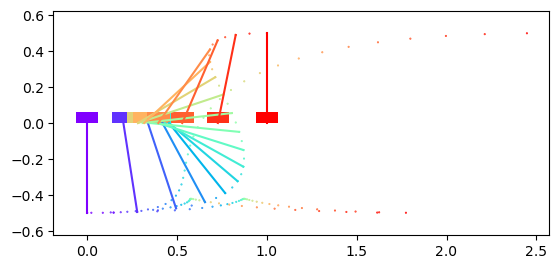

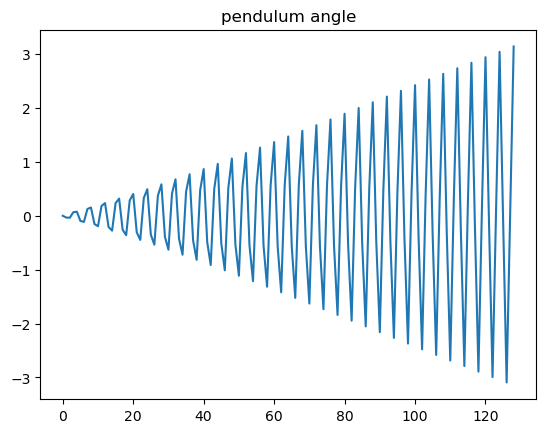

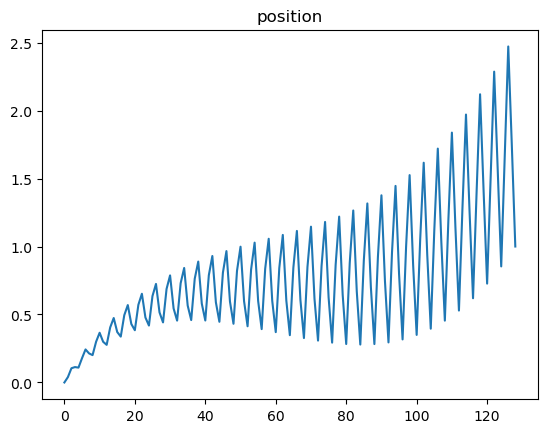

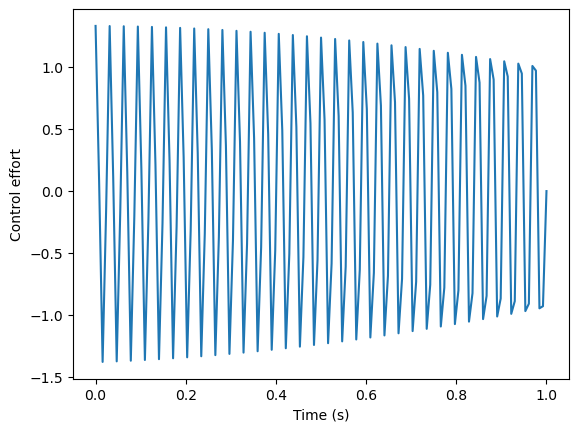

128
128
128
128
C shape:  (258, 645)
C shape:  (258, 645)
Fs[0]: [[  0.    0.    1.    0. ]
 [  0.    0.    0.    1. ]
 [  0.    9.8   0.    0. ]
 [  0.  -39.2   0.   -0. ]]
bs[0]: [ 0.  0.  1. -1.]
f_0s[0]: [0. 0. 0. 0.]
relin step: 1
ifsnm num iters: 0 residual norm: 453.3583390500328 line search param: 1.0
ifsnm num iters: 1 residual norm: 0.014914556156674042 line search param: 1.0
ifsnm num iters: 2 residual norm: 1.0712766759677648e-07 line search param: 1.0
ifsnm num iters: 3 residual norm: 3.7161320898967436e-10 line search param: 0.81
feasible newton
entering fsnm loop
newton decrement: 0.011853822770450067
fsnm num iters: 0 line search: 0.9 newton decrement: 0.011853822770450067
fsnm num iters: 1 line search: 0.9 newton decrement: 0.0011853756925179243
fsnm num iters: 2 line search: 1.0 newton decrement: 0.00011853750329513593
fsnm num iters: 3 line search: 1.0 newton decrement: 7.319465318915553e-12
feasible newton
entering fsnm loop
newton decrement: 0.0011881671607951684
f

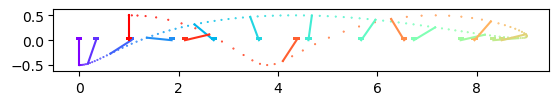

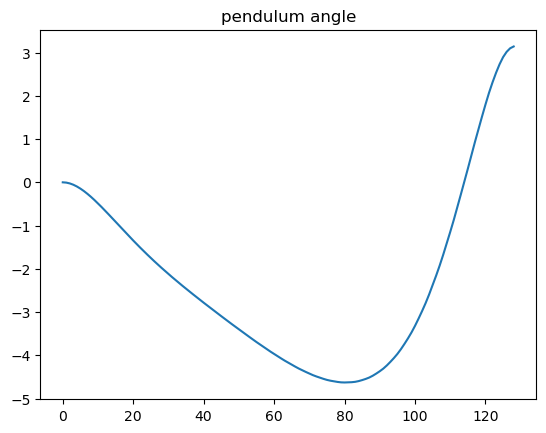

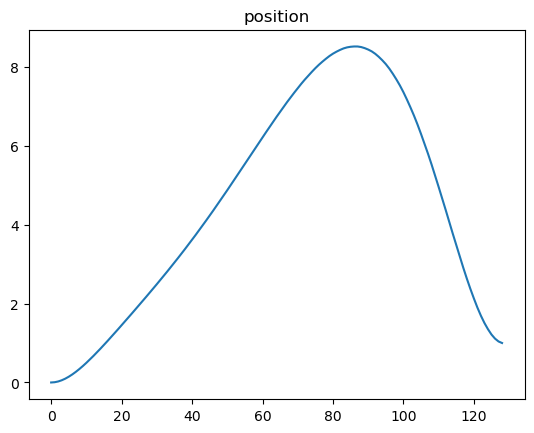

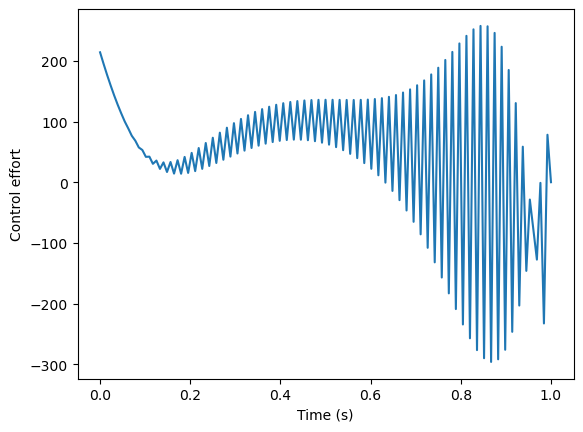

128
128
128
128
C shape:  (258, 645)
C shape:  (258, 645)
Fs[0]: [[  0.    0.    1.    0. ]
 [  0.    0.    0.    1. ]
 [  0.    9.8   0.    0. ]
 [  0.  -39.2   0.   -0. ]]
bs[0]: [ 0.  0.  1. -1.]
f_0s[0]: [0. 0. 0. 0.]
relin step: 2
ifsnm num iters: 0 residual norm: 950787.9702090382 line search param: 0.16677181699666577
ifsnm num iters: 1 residual norm: 792223.3328911011 line search param: 0.0017970102999144335
ifsnm num iters: 2 residual norm: 790799.6994675068 line search param: 0.0225283995449392
ifsnm num iters: 3 residual norm: 772984.5463197295 line search param: 0.0984770902183612
ifsnm num iters: 4 residual norm: 696863.2783307896 line search param: 0.005726416897022355
ifsnm num iters: 5 residual norm: 692872.7488804543 line search param: 0.001996678111016037
ifsnm num iters: 6 residual norm: 691489.3073839579 line search param: 0.01824800363140075
ifsnm num iters: 7 residual norm: 678871.0434080424 line search param: 0.2058911320946491
ifsnm num iters: 8 residual norm: 5

False

In [47]:
better_cartpole_trajectory_optimizer(N, T, control_weighting, z_0, z_final, dynamics, filename="ohyeah")

In [ ]:
def find_feasible_times():
   # Number of timesteps
   N = 64
   # Total amount of time
   T = 1.5
   
   control_weighting = np.ones(N + 1)
   
   u_min = -30.0
   u_max = 30.0
   
   z_0 = np.array([0.0, 0.0, 0.0, 0.0])
   z_final = np.array([2.0, np.pi, 0.0, 0.0])
   
   m_pend = 0.3
   m_cart = 0.3
   l_pend = 0.5

   good_ts = []
   
   for i in range(30):
      print("-----------Time",T,"--------------")
      good = cartpole_trajectory_optimizer(N, T, control_weighting, u_min, u_max, z_0, z_final, m_pend, m_cart, l_pend, plot_stuff=True)
      if good:
         good_ts.append(T)
         T -= 0.01
      else:
         print("---------bad time--------------")
         break
   
   print("Good times for swing-up:", good_ts)
      

In [19]:
#find_feasible_times()